In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
df = pd.read_csv('Datasets/airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df['LogPassengers'] = np.log(df['Passengers'])

In [5]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [6]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [7]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [8]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [9]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [10]:
# CNN
i = Input(shape=(T, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model = Model(i, x)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 8, 16)             64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33    

In [12]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [13]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

Epoch 1/100
4/4 [==============================] - 7s 106ms/step - loss: 0.0115 - val_loss: 0.0088
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0099 - val_loss: 0.0091
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0094 - val_loss: 0.0086
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0073
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 9/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 11/100
4/4 [

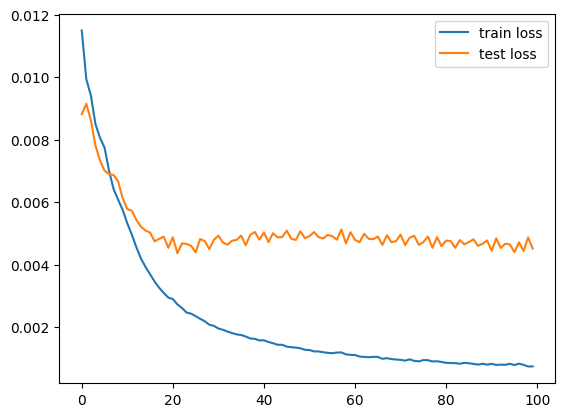

In [14]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [15]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [17]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 23ms/step


In [18]:
# Store diff predictions
df.loc[train_idx, 'Diff Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff Test Prediction'] = Ptest

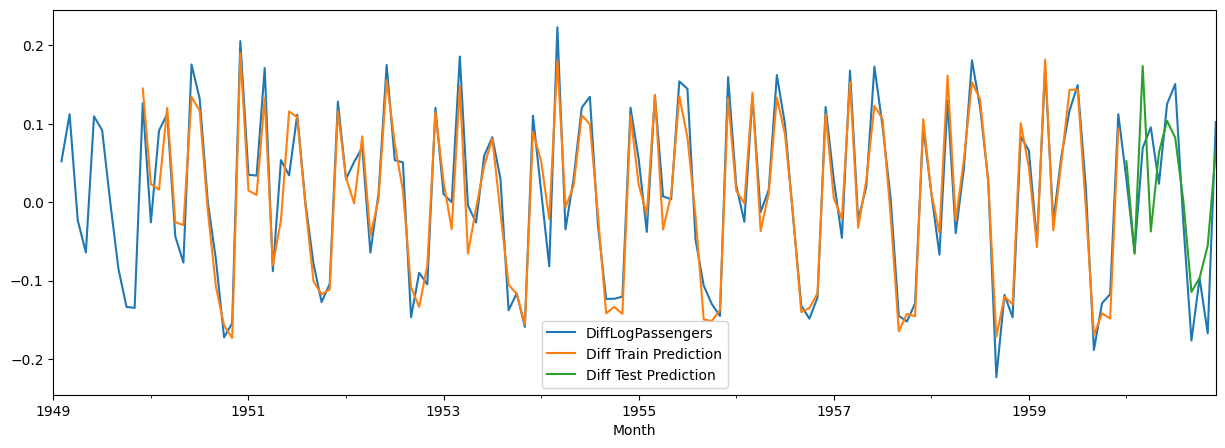

In [19]:
cols = ['DiffLogPassengers',
        'Diff Train Prediction',
        'Diff Test Prediction']
df[cols].plot(figsize=(15, 5));

In [20]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [21]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [22]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

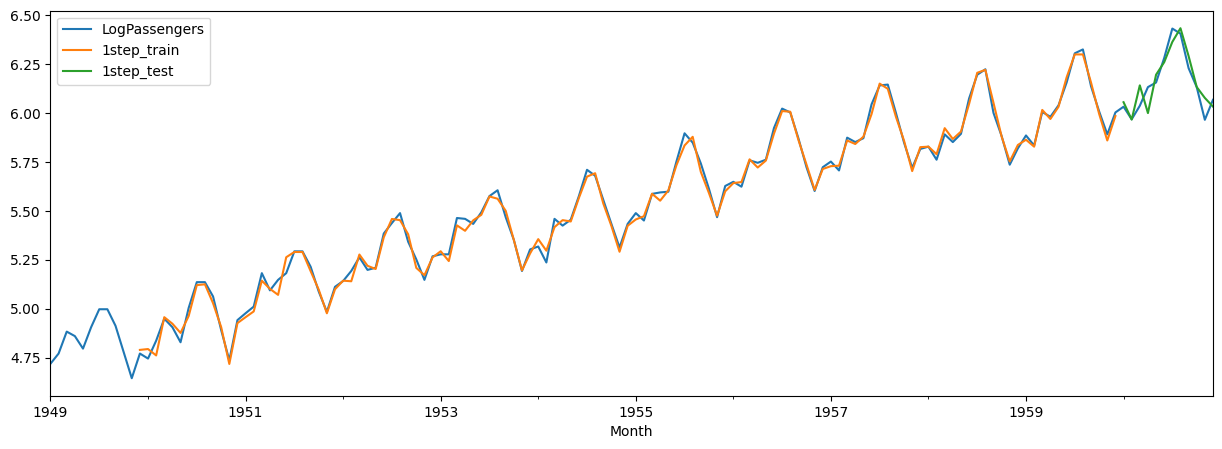

In [23]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [24]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 18ms/step


In [25]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

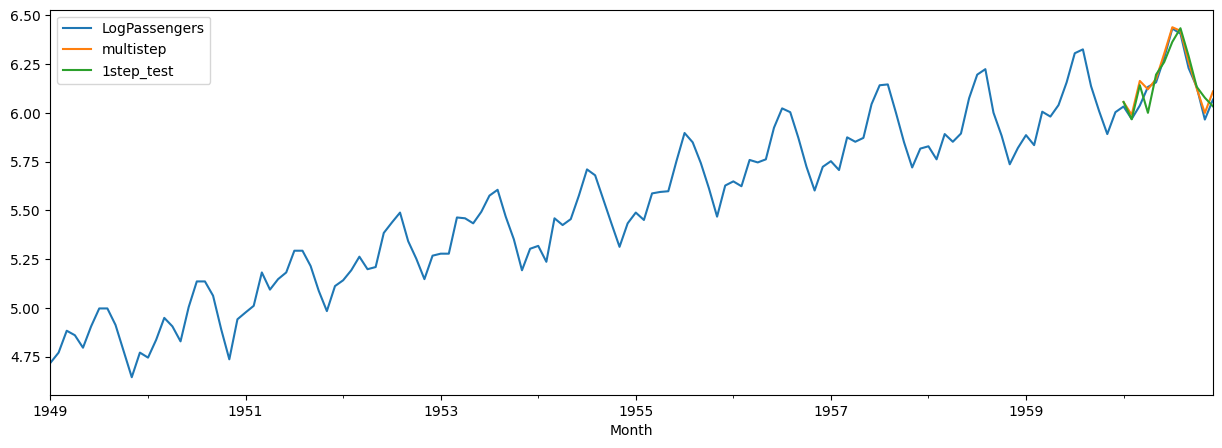

In [26]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [27]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [28]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [29]:
# CNN
i = Input(shape=(Tx, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [30]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [31]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=200,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/200
4/4 [==============================] - 1s 44ms/step - loss: 0.0121 - val_loss: 0.0105
Epoch 2/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0115 - val_loss: 0.0099
Epoch 3/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0111 - val_loss: 0.0096
Epoch 4/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0109 - val_loss: 0.0093
Epoch 5/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 6/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0104 - val_loss: 0.0088
Epoch 7/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0102 - val_loss: 0.0086
Epoch 8/200
4/4 [==============================] - 0s 22ms/step - loss: 0.0100 - val_loss: 0.0083
Epoch 9/200
4/4 [==============================] - 0s 18ms/step - loss: 0.0098 - val_loss: 0.0080
Epoch 10/200
4/4 [==============================] - 0s 20ms/step - loss: 0.0096 - val_loss: 0.0078
Epoch 11/200
4/4 [=

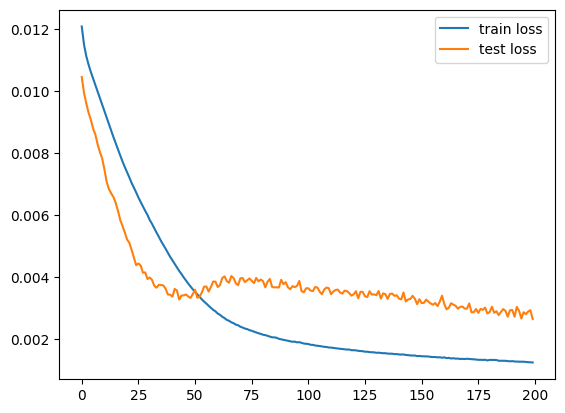

In [32]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [33]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 32ms/step


In [34]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [35]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

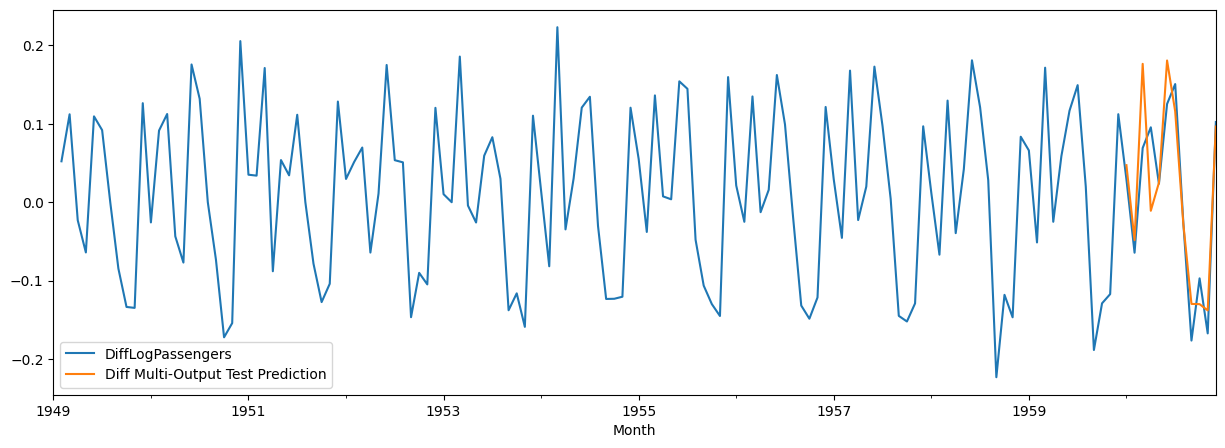

In [36]:
df.loc[test_idx, 'Diff Multi-Output Test Prediction'] = Ptest
cols = ['DiffLogPassengers', 'Diff Multi-Output Test Prediction']
df[cols].plot(figsize=(15, 5));

In [37]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

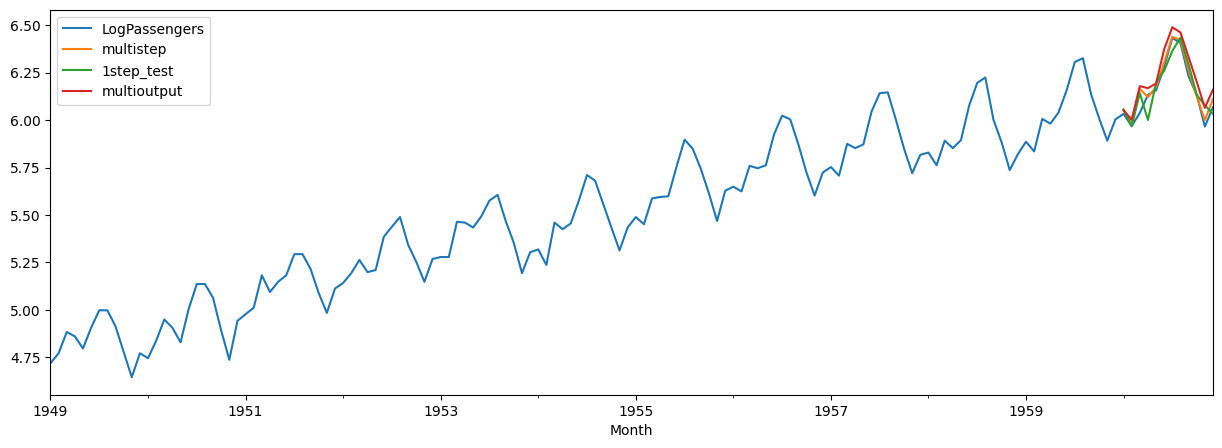

In [38]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [39]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.004917953666385475
multi-output MAPE: 0.011261541385272425


In [ ]:
# Exercise:
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?